# Máquinas de Vector Soporte (SVM) para el Análisis de Pymes (SME)
### Del Espacio de Características a las Probabilidades: Un enfoque de Hiperparametrización

¡Bienvenidos! En esta sesión, utilizaremos las **Máquinas de Vector Soporte (SVM)** para predecir el estatus de formalidad de las PyMEs. 

A diferencia de las Redes Neuronales (MLP), las SVM no buscan minimizar un error global mediante gradiente, sino maximizar el margen de separación entre clases. Hoy aprenderemos:
1.  **Cómo estima probabilidades una SVM** (Escalamiento de Platt).
2.  **Construcción de un Pipeline** con escalado y selección de variables.
3.  **Búsqueda de Hiperparámetros** enfocada en el Kernel y la Regularización ($C$).

---

## 1. Nota Teórica: ¿Cómo estima la SVM la probabilidad?

Las SVM son, por definición, clasificadores **no probabilísticos**. El algoritmo simplemente calcula una función de decisión $f(x)$ que representa la distancia de un punto al hiperplano separador. 

Para obtener una probabilidad (un valor entre 0 y 1) como lo haría una Regresión Logística, Scikit-Learn implementa el **Escalamiento de Platt (Platt Scaling)**:

1.  Se entrena la SVM normalmente.
2.  Se utiliza el valor de la función de decisión $f(x)$ como entrada para un nuevo modelo: una **Regresión Logística**.
3.  La fórmula es: $P(y=1|x) = 1 / (1 + exp(A * f(x) + B))$, donde $A$ y $B$ son parámetros aprendidos mediante validación cruzada.

**Importante para Posgrado**: Este proceso requiere activar `probability=True` en Scikit-Learn, lo cual realiza internamente una validación cruzada de 5 pliegues para entrenar el modelo de probabilidad, aumentando el tiempo de cómputo pero garantizando que las probabilidades no estén sesgadas.

## 2. Configuración del Entorno

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_curve, auc, classification_report, roc_auc_score
)

# Configuración estética
sns.set_theme(style="whitegrid")
plt.rcParams['figure.dpi'] = 100
BLUE = '#003882'
VIBRANT_PURPLE = '#7153ff'

## 3. Carga y Preparación de Datos

In [2]:
# Cargar el dataset
df = pd.read_csv('../data/sme_mx.csv')

# Filtrado y mapeo de target
df_filtered = df[df['altaSAT'] != 'o'].copy()
df_filtered['target'] = df_filtered['altaSAT'].map({'s': 1, 'n': 0})

cols_to_keep = [
    'edadEmprendedor', 'sexoEmprendedor', 'escolaridadEmprendedor', 
    'dependientesEconomicos', 'estadoCivil', 'familiaAyuda', 
    'antiguedadNegocio', 'giroNegocio', 'numEmpleados', 
    'ventasPromedioDiarias', 'registroVentas', 'registroContabilidad', 
    'usaCredito', 'tiempoCreditoProveedores', 'target'
]

df_model = df_filtered[cols_to_keep].dropna().copy()
X = df_model.drop(columns=['target'])
y = df_model['target']

# Encoding
X_encoded = pd.get_dummies(X, drop_first=True)

# Partición
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.25, random_state=42, stratify=y)

print(f"Dataset preparado: {X_train.shape[0]} registros de entrenamiento y {X_test.shape[0]} de prueba.")

Dataset preparado: 532 registros de entrenamiento y 178 de prueba.


## 4. Pipeline y Búsqueda de Hiperparámetros

Construiremos un pipeline que:
1.  **Escale** los datos (Las SVM son extremadamente sensibles a la escala).
2.  **Seleccione** las mejores $k$ variables.
3.  **Entrene** el modelo `SVC` con el parámetro `probability=True`.

In [3]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', SelectKBest(score_func=f_classif)),
    ('svm', SVC(probability=True, random_state=42))
])

# Definición del espacio de búsqueda
param_distributions = {
    'selector__k': [10, 20, 40, 'all'],
    'svm__C': [0.1, 1, 10, 100],           
    'svm__gamma': ['scale', 'auto', 0.1, 0.01], 
    'svm__kernel': ['rbf', 'poly', 'sigmoid'] 
}

print("Iniciando búsqueda de hiperparámetros para SVM...")
random_search = RandomizedSearchCV(
    pipeline, 
    param_distributions, 
    n_iter=15, 
    cv=3, 
    scoring='roc_auc', 
    random_state=42, 
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train, y_train)

print(f"Mejor ROC AUC Score en validación: {random_search.best_score_:.4f}")
print(f"Mejores parámetros: {random_search.best_params_}")

Iniciando búsqueda de hiperparámetros para SVM...
Fitting 3 folds for each of 15 candidates, totalling 45 fits


/Users/gus/trabajo/academia/improved-potato/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [ 8 20 21 23 24 25 27 35 37 38 39 40 42 43 47 48 52 54 64 65 67 70 71 72
 75 78 79 85 86 87 89 93 94] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/gus/trabajo/academia/improved-potato/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [19 24 25 26 27 28 29 30 31 37 38 41 46 48 56 57 58 59 64 66 67 68 69 75
 77 79 83 85 86 87 93] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/gus/trabajo/academia/improved-potato/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/gus/trabajo/academia/improved-potato/.venv/lib/python3.13/site-packages/sklearn/featur

Mejor ROC AUC Score en validación: 0.7659
Mejores parámetros: {'svm__kernel': 'sigmoid', 'svm__gamma': 'auto', 'svm__C': 1, 'selector__k': 40}


/Users/gus/trabajo/academia/improved-potato/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [19 24 25 26 27 28 29 30 31 37 38 41 46 48 56 57 58 59 64 66 67 68 69 75
 77 79 83 85 86 87 93] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/gus/trabajo/academia/improved-potato/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/gus/trabajo/academia/improved-potato/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [22 24 25 27 36 37 38 48 50 51 53 55 60 61 62 64 67 74 75 79 81 85 86 87
 88 90 93] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/gus/trabajo/academia/improved-potato/.venv/lib/python3.13/site-packages/sklearn/feature_selection/_univa

## 5. Evaluación y Visualización de Resultados

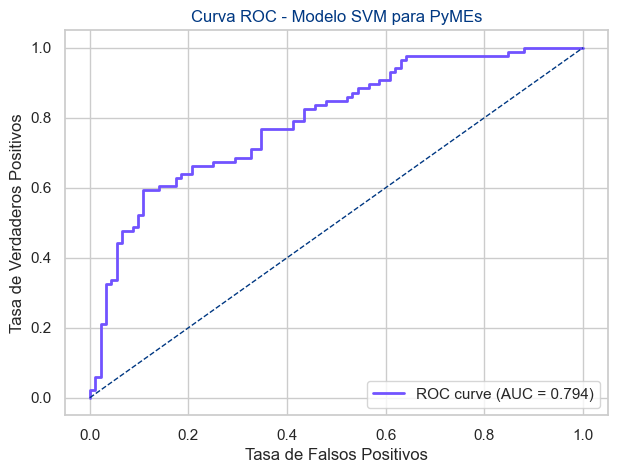

Reporte de Clasificación en el Set de Prueba:
              precision    recall  f1-score   support

           0       0.71      0.73      0.72        92
           1       0.70      0.67      0.69        86

    accuracy                           0.70       178
   macro avg       0.70      0.70      0.70       178
weighted avg       0.70      0.70      0.70       178



In [5]:
best_model = random_search.best_estimator_
y_probs = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

# Cálculo de métricas
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color=VIBRANT_PURPLE, lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color=BLUE, lw=1, linestyle='--')
plt.title('Curva ROC - Modelo SVM para PyMEs', color=BLUE)
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc="lower right")
plt.show()

print("Reporte de Clasificación en el Set de Prueba:")
print(classification_report(y_test, y_pred))

---
### Resumen
1.  **Sensibilidad al Escalamiento**: Notarán que sin el `StandardScaler`, la SVM tardaría mucho más en converger o daría resultados pobres, ya que las distancias dependen de las unidades.
2.  **C y el Margen**: Un $C$ bajo (0.1) crea un margen más permisivo, mientras que un $C$ alto (100) intenta clasificar correctamente cada punto del entrenamiento, arriesgándose al sobreajuste.
3.  **Kernel RBF**: Es el más común por su capacidad de mapear los datos a un espacio de dimensión infinita de forma implícita.

**Sugerencia Didáctica**: Intenten cambiar el kernel a `linear` en el diccionario de parámetros para ver si el problema de las PyMEs es separable linealmente o requiere forzosamente de no linealidad.

best_model

In [ ]:
best_m

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('selector', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"score_func score_func: callable, default=f_classifFunction taking two arrays X and y, and returning a pair of arrays(scores, pvalues) or a single array with scores.Default is f_classif (see below ""See Also""). The default function onlyworks with classification tasks... versionadded:: 0.18",<function f_c...t 0x11c85bb00>
,"k k: int or ""all"", default=10Number of top features to select.The ""all"" option bypasses selection, for use in a parameter search.",40
,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'sigmoid'
